# Demo of Risk-aware Path Planning Algorithm
## Before Starting
Please prepare virtual environments with Python 3.9.10 and install necessary libraries by running the following commands.
```
(.venv) $ pip install -e .
```

In [1]:
import sys, os
BASE_PATH = os.path.dirname("__file__")

from planning_project.env.env import GridMap
from planning_project.env.slip_models import SlipModel, SlipModelsGenerator
from planning_project.env.utils import SlipDistributionMap
from planning_project.planner.planner import AStarPlanner
from planning_project.utils.data import DataSet, create_int_label
from scripts.eval import PlanMetrics

 /home/endo/repos/safe-rover-navi/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# set parametric information
idx_dataset = 'Std' # either [Std, ES, AA]
if idx_dataset == 'Std' or idx_dataset == 'ES':
    n_terrains = 10
elif idx_dataset == 'AA':
    n_terrains = 8
res = 1
start_pos = (8, 8)
goal_pos = (88, 88)
idx_instance = 0
type_model = "gsm"
type_embed = "mean"
if type_embed == "mean":
    alpha = None
else:
    alpha = 0.99

In [3]:
# set directory paths to classifiers and testing data
nn_model_dir = os.path.join(
    BASE_PATH,
    '../trained_models/models/dataset_%s/best_model.pth' % (idx_dataset)
)
data_dir = os.path.join(
    BASE_PATH,
    '../datasets/dataset_%s/' % (idx_dataset)
)

In [4]:
dataset = DataSet(data_dir, "test")
smg = SlipModelsGenerator(
    dirname=data_dir,
    n_terrains=n_terrains
)
planner = AStarPlanner(
    map=None,
    smg=smg,
    nn_model_dir=nn_model_dir
)
plan_metrics = PlanMetrics(
    is_plan=True,
    type_model=type_model,
    type_embed=type_embed,
    alpha=alpha
)

 /home/endo/repos/safe-rover-navi/.venv/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [5]:
# set map instance for planning
color, mask = dataset[idx_instance]
color = dataset.to_image(color)
mask = create_int_label(dataset.to_image(mask))
height = dataset.get_height_map(idx_instance)

grid_map = GridMap(color.shape[1], res)
grid_map.load_env(height, mask, color)
sdm = SlipDistributionMap(grid_map, smg)
grid_map.data.slip = sdm.set_slip()

In [6]:
planner.reset(
    map=grid_map,
    start_pos=start_pos,
    goal_pos=goal_pos,
    plan_metrics=plan_metrics
)
_, _ = planner.search_path()
metrics = planner.execute_final_path()

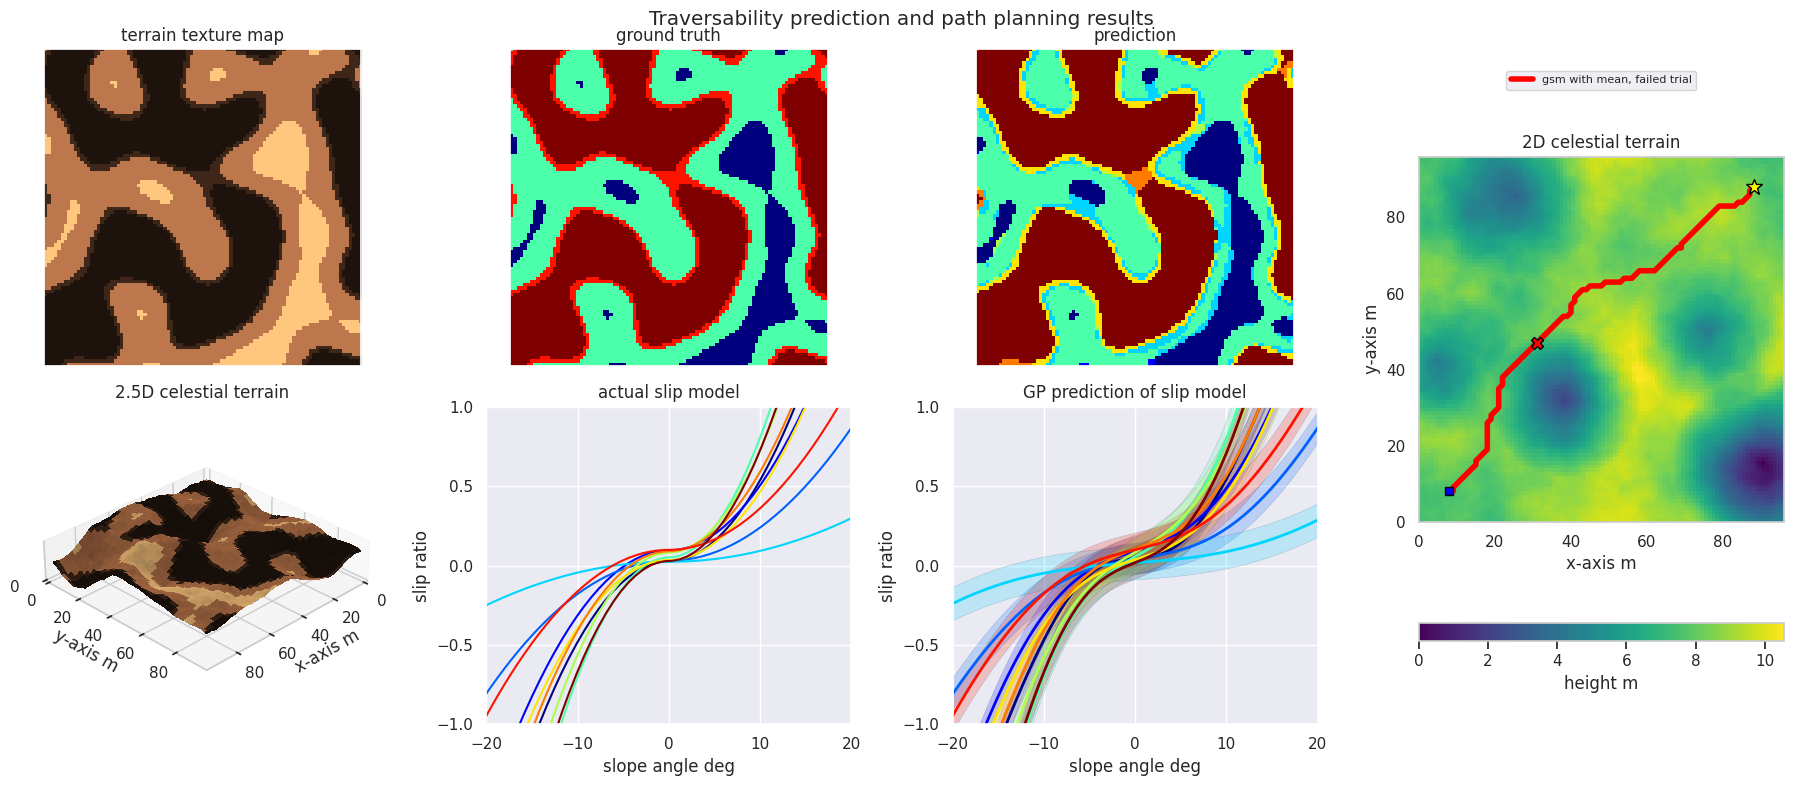

In [7]:
fig, ax = planner.plot_envs(figsize=(18, 8))
planner.plot_terrain_classification(fig)
planner.plot_final_path(
    ax=ax,
    metrics=metrics,
    color="red",
    plan_type="%s with %s" % (plan_metrics.type_model, plan_metrics.type_embed)
)